This script performs a spectral decomposition of the full longwave equation.


##### Ground exchange (GX)
GX  = $[B_s - B(\tau)] \exp[-(\tau_s - \tau)]$
where

$B_s$ is the source function of the ground

$B(\tau_s)$ is the source function of the atmosphere at the surface

$B(\tau)$ is the source function at $\tau$

Discontinuities in temperature between the ground and the atmosphere are accounted for in GX.

#### Cooling-to-space (CTS)

CTS = $-B(\tau) \exp(-\tau)$

where

$B(\tau)$ is the source function at each level of the atmosphere

$\tau$ is the optical depth at each level of the atmosphere

#### Exchange Below ($EX_b$)

$EX_b = \int_\tau^{\tau_s} [B(\tau')-B(\tau)] \exp[-(\tau'-\tau)]\: d\tau'$

where $\tau$ is the optical depth of the level of interest, $\tau'$ is the integration variable, and $\tau_s$ is the optical depth of the atmosphere at the surface.

#### Exchange Above ($EX_a$)

$EX_a = \int_0^\tau [B(\tau')-B(\tau)] \exp[-(\tau-\tau')]\: d\tau'$

where $\tau$ is the optical depth of the level of interest and $\tau'$ is the integration variable.

#### Conversion from $W*cm/m^2$ to $W*cm/m^3$

$\partial_z F = \partial_z \tau \: \partial_\tau F$

In [1]:
# Load dependencies
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib import cm
from cmcrameri import cm as cmc # scientific colormaps
import matplotlib.colors as mcolors # for norms
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, ScalarFormatter, NullFormatter)
from scipy import ndimage
import matplotlib.colors as mcolors #for norms
from matplotlib.colors import ListedColormap
from matplotlib.patches import FancyArrowPatch
from collections.abc import Sequence
from typing import Type,Dict,Tuple
import pandas as pd
import scipy
import rfmtools
from scipy.interpolate import interp1d

def get_hr(dataset):
    #############################################################
    # Unpack the inputs
    par     = dataset['par']
    heights = dataset['RFM']['z']
    #############################################################
    srhr = [] # spectrally-resolved heating rate at each height (levs,nus)
    hr   = [] # spectrally-integ.   heating rate at each height (levs)
    fdir = '/home/fspauldinga/SAM24a/RFM/outp/%s'%par.case
    for height in heights:
        if height<100:
            df = '%s/coo_0000%i.asc' %(fdir,height)
        elif height<1000:
            df = '%s/coo_00%i.asc' %(fdir,height)
        elif height<10000:
            df = '%s/coo_0%i.asc' %(fdir,height)
        else:
            df = '%s/coo_%i.asc' %(fdir,height)
        # append spect-res. hr at each height
        srhr.append(np.loadtxt(df,skiprows=4))   
    srhr = np.array(srhr)    
    
    # Retain only the band information
    srhr = srhr[:,par.i0:par.i1+1] 
    
    # Calculate the band-integrated cooling rate (K/day)
    hr.append(par.dnu*np.sum(srhr,axis=1)) 
    hr = np.squeeze(np.array(hr))
    return {'hr':hr,'srhr':srhr} 

def get_odepth(dataset)->dict[str,float]:
    #############################################################
    # Unpack the inputs
    par     = dataset['par']
    heights = dataset['RFM']['z']
    #############################################################
    # odepth uses an internal decision for crdnu
    crdnu = 40 # cm-1
    #############################################################
    srtau    = []  # spectrally-resolved optical depth at each height (levs,nus)
    zsrtau1  = []  # tau=1 heights as a function of nu (nus)
    D        = 1.5 # two-stream diffusivity factor
    fdir     = rfmtools.utils.RFM_DIR+'/outp/%s'%par.case
    for height in heights:
        if height<100:
            df = '%s/opt_0000%i.asc' %(fdir,height)
        elif height<1000:
            df = '%s/opt_00%i.asc' %(fdir,height)
        elif height<10000:
            df = '%s/opt_0%i.asc' %(fdir,height)
        else:
            df = '%s/opt_%i.asc' %(fdir,height)
        # append spect-res. tau at each height
        srtau.append(np.loadtxt(df,skiprows=4))   
    srtau = D*np.array(srtau)
    #srtau  = np.array(srtau)
      
    # "walk the line" and find z(nu | tau=1)
    for n,nu in enumerate(par.nus):
        #k1 = np.where(np.abs(1-D*srtau[:,n])==np.min(np.abs(1-D*srtau[:,n])))
        k1 = np.where(np.abs(1-srtau[:,n])==np.min(np.abs(1-srtau[:,n])))
        zsrtau1.append(heights[k1])
    zsrtau1 = np.squeeze(np.array(zsrtau1))
    
    # retain information from the spectral band
    srtau   = srtau[:,par.i0:par.i1+1]
    zsrtau1 = zsrtau1[par.i0:par.i1+1]
        
    # Compute linear averages over coarse 10 cm-1 bins
    crnus     = np.arange(par.nu0+crdnu/2,par.nu1+crdnu/2,crdnu)
    bin_edges = np.arange(par.nu0,par.nu1+crdnu,crdnu)
    bin_means,bin_edges,binnumber = scipy.stats.binned_statistic(par.nus[par.i0:par.i1+1], srtau, statistic='mean', bins=bin_edges)
    crsrtau   = bin_means
    
    bin_edges = np.arange(par.nu0,par.nu1+crdnu,crdnu)
    bin_means,bin_edges,binnumber = scipy.stats.binned_statistic(par.nus[par.i0:par.i1+1], zsrtau1, statistic='mean', bins=bin_edges)
    crzsrtau1 = bin_means
        
    return {'srtau':srtau,'zsrtau1':zsrtau1,'crnus':crnus,'crsrtau':crsrtau,'crzsrtau1':crzsrtau1}

def get_bint_planck(dataset)->Dict[str,float]:
    #############################################################
    # Unpack the inputs
    par     = dataset['par']
    heights = dataset['RFM']['z']
    temps   = dataset['RFM']['T']
    #############################################################
    def get_B(nu:Sequence[float],T:int)->Dict[str,float]:
        # Planck emission ((W/m2)*cm) as a function of wavenumber (nu; array; cm-1) and temperature (T; scalar; K)
        nu = nu*100 # 1/cm -> 1/m
        h = 6.626e-34 # J*s
        c = 3.0e8     # m/s
        k = 1.38e-23  # J/K
        B = 2*h*c**2*nu**3/(np.exp((h*c*nu)/(k*T))-1) # kg*m/s^2 = W m^(-2) m^(+1)
        B = 100*B # W m^(-2) m^(+1) -> W*cm/m^2
        return {'B':B}
    #############################################################
    # Compute the band-integrated planck emission
    #############################################################
    piBsr    = [] # spectrally-resolved planck emission (W*cm/m^2)
    piBbar   = [] # band-integrated planck emission (W/m^2)
    #############################################################
    # at each height, get spectrally-resolved B and band-integrate
    for k,height in enumerate(heights):
        data = get_B(par.nus[par.i0:par.i1+1],temps[k])
        integrand = np.pi*data['B']
        piBsr.append(integrand)
        piBbar.append(np.trapz(integrand,par.nus[par.i0:par.i1+1]))
    piBsr    = np.array(piBsr)
    piBbar = np.array(piBbar)
    return {'piBsr':piBsr,'piBbar':piBbar}   

def get_custom_atm(par,vres1=np.arange(0,3e4,1e2),vres2=np.arange(0,3e4,1e2)):
    # scalar inputs: mid-tropospheric RH (RHmid) and temeprature (Tmid) and boolean option for uniform RH
    # Vertical resolution can also be specified to facilitate RFM vs analytical model. 
    #############################################################
    def get_optimal_RH(Tsfc2trp, Ts=300, Tmid=260, Ttrp=200, RHs=0.75, RHmid=0.4, RHtrp=0.75):
        print('Ts',Ts)
        print('Tmid',Tmid)
        print('Ttrp',Ttrp)
        print('RHs',RHs)
        print('RHmid',RHmid)
        print('RHtrp',RHtrp)
        # Compute alpha_left and alpha_right based on target RH values
        alpha_left  = -np.log(RHtrp / RHmid)/(Ttrp - Tmid) ** 2
        alpha_right = -np.log(RHs / RHmid)/(Ts - Tmid) ** 2 
        # Compute RH values for the provided temperature range
        RH_opt = [
            RHmid * np.exp(-(temp - Tmid) ** 2 * alpha_left) if temp < Tmid else RHmid * np.exp(-(temp - Tmid) ** 2 * alpha_right)
            for temp in Tsfc2trp
        ]
        return {'RH':RH_opt,'alpha_lt':alpha_left, 'alpha_gt':alpha_right}
    #############################################################
    def get_esat_over_l(par,T):
        import math
        # SVP over liquid from DAM (Pa)
        xi = 10 # factor to change the SVP
        pstar = xi*par.ptrip * (T/par.Ttrip)**((par.cpv-par.cvl)/par.rgasv) * math.exp( (par.E0v - (par.cvv-par.cvl)*par.Ttrip) / par.rgasv * (1/par.Ttrip - 1/T) )
        return pstar
    #############################################################
    # Lapse Rate and Temperature (Troposphere)
    Gamma = np.ones([len(par.z)],dtype='float')*par.Gamma
    T  = par.Ts - par.Gamma*par.z
    # stratospheric mask
    mask = np.where(T<par.Ttrp)
    # Lapse Rate and Temperature (Stratosphere)
    T  = np.where(T<par.Ttrp,par.Ttrp,T)
    Gamma[mask] = 0
    # Identify the height of the tropopause
    ktrp = int(np.amin(np.where(T==par.Ttrp)))
    ztrp = par.z[ktrp]
    # Custom RH
    if par.uniform is True:
        RH       = np.ones([len(par.z)])*par.RHmid
        RH[mask] = 0
        alpha_lt = 0
        alpha_gt = 0
    else:
        RH  = np.ones([len(par.z)])*par.RHs
        RH[mask] = 0 # stratospheric mask
        foo = get_optimal_RH(T[0:(ktrp+1)], par.Ts, par.Tmid, par.Ttrp, par.RHs, par.RHmid, par.RHtrp)
        RH[0:(ktrp+1)] = foo['RH']
        alpha_lt       = foo['alpha_lt']
        alpha_gt       = foo['alpha_gt']
    
    # Solve for environmental pressure and density 
    rho  = np.zeros_like(par.z)
    p    = np.ones_like(par.z)*par.ps
    arg  = 0
    # initialize molar mixing ratios (relative to total)
    xN2  = np.zeros_like(par.z)
    xO2  = np.zeros_like(par.z)
    xH2O = np.zeros_like(par.z)
    xCO2 = np.zeros_like(par.z)
    # initialize mass mixing ratios (relative to total)
    wN2  = np.zeros_like(par.z)
    wO2  = np.zeros_like(par.z)
    wH2O = np.zeros_like(par.z)
    wCO2 = np.zeros_like(par.z)
    # initialize specific gas constant
    Rtot  = np.zeros_like(par.z)
    # initialize mean molecular mass
    Mave  = np.zeros_like(par.z)
    # initialize specific heat of air
    cp    = np.zeros_like(par.z) # J/kg/K
    cpmol = np.zeros_like(par.z) # J/mol/K
    for k in range(len(par.z)):
        if k<(len(par.z)-1):
            dz   = par.z[k+1]-par.z[k]
        else:
            dz   = par.z[1]-par.z[0]
        # molar mixing ratio of H2O
        if k<=ktrp: # tropospheric value set by Clausius-Clapeyron
            pH2O    = RH[k]*get_esat_over_l(par,T[k])
            xH2O[k] = pH2O/p[k]
        else: # stratospheric mixing ratio fixed to tropopause value
            xH2O[k] = xH2O[ktrp]
        # Compute dry-air scaling factor (applies to N2, O2, and CO2)
        scaling_factor = 1 - xH2O[k]  # The fraction of dry air remaining
        # Apply fixed dry-air composition (keeping N2, O2, and CO2 proportions constant in dry-air)
        xN2[k]  = scaling_factor * par.xN2             # 78%
        xCO2[k] = scaling_factor * par.xCO2            # 395 ppm
        xO2[k]  = scaling_factor * par.xO2 - xCO2[k]   # ~22% (note: robbing from over-estimated O2)
        tol = 1e-6 # tolerance for precision in mole fractions
        if abs(par.xN2+par.xO2-1)>tol:
            print('Error: sum of dry-air abundances of N2,O2 is non-unity. Tolerance exceeded')
        if abs(xN2[k] + xO2[k] + xH2O[k] + xCO2[k] - 1) > tol:
            print(f'Error: sum of molar fractions is non-unity. Tolerance exceeded.')
            #print(abs(xN2[k] + xO2[k] + xH2O[k] + xCO2[k] - 1))
        # mean molecular weight of air
        Mave[k]  = xN2[k]*par.MN2 + xO2[k]*par.MO2 + xH2O[k]*par.MH2O + xCO2[k]*par.MCO2
        # molar specific heat of air (J/mol/K)
        cpmol[k] = xN2[k]*par.cpmolN2 + xO2[k]*par.cpmolO2 + xH2O[k]*par.cpmolH2O + xCO2[k]*par.cpmolCO2
        # mass mixing ratios of N2, O2, H2O, CO2
        wN2[k]  = xN2[k] *par.MN2/Mave[k]
        wO2[k]  = xO2[k] *par.MO2/Mave[k]
        wH2O[k] = xH2O[k]*par.MH2O/Mave[k]
        wCO2[k] = xCO2[k]*par.MCO2/Mave[k]
        if abs(wN2[k] + wO2[k] + wH2O[k] + wCO2[k] - 1) > tol:
            print(f'Error: sum of mixing ratios is non-unity. Tolerance exceeded.')
        # specific heat of air (J/kg/K)
        cp[k] = wN2[k]*par.cpN2 + wO2[k]*par.cpO2 + wH2O[k]*par.cpH2O + wCO2[k]*par.cpCO2
        # specific gas constant of air
        Rtot[k]  = wN2[k]*par.RN2 + wO2[k]*par.RO2 + wH2O[k]*par.RH2O + wCO2[k]*par.RCO2
        # solve for total density of air
        rho[k] = p[k]/(Rtot[k]*T[k])
        # solve for exponential term
        arg    = -par.ggr/Rtot[k]*dz/T[k]
        # solve for pressure at next level
        if k<(len(par.z)-1):
            p[k+1] = p[k]*np.exp(arg)
    #############################################################
    # Export fields in their desired vertical resolution (vres1,vres2)
    def interpolate(var, vres):
        # func = interp1d(par.z,var,kind)(input of function)
        return interp1d(par.z, var, kind='cubic')(vres)
    T1, T2         = interpolate(T, vres1), interpolate(T, vres2)
    Gamma1, Gamma2 = interpolate(Gamma, vres1), interpolate(Gamma, vres2)
    p1, p2         = interpolate(p, vres1), interpolate(p, vres2)
    rho1, rho2     = interpolate(rho, vres1), interpolate(rho, vres2)
    RH1, RH2       = interpolate(RH, vres1), interpolate(RH, vres2)
    xN2_1, xN2_2   = interpolate(xN2, vres1), interpolate(xN2, vres2)
    xO2_1, xO2_2   = interpolate(xO2, vres1), interpolate(xO2, vres2)
    xH2O_1, xH2O_2 = interpolate(xH2O, vres1), interpolate(xH2O, vres2)
    xCO2_1, xCO2_2 = interpolate(xCO2, vres1), interpolate(xCO2, vres2)
    cp1, cp2       = interpolate(cp, vres1), interpolate(cp, vres2)
    cpmol1, cpmol2 = interpolate(cpmol, vres1), interpolate(cpmol, vres2)
    #############################################################
    dat1 = {'T': T1, 'p': p1, 'Gamma': Gamma1, 'rho': rho1, 'z': vres1, 'RH': RH1,
            'xN2': xN2_1, 'xO2': xO2_1, 'xH2O': xH2O_1, 'xCO2': xCO2_1, 'cp':cp1, 'cpmol':cpmol1}
    dat2 = {'T': T2, 'p': p2, 'Gamma': Gamma2, 'rho': rho2, 'z': vres2, 'RH': RH2,
            'xN2': xN2_2, 'xO2': xO2_2, 'xH2O': xH2O_2, 'xCO2': xCO2_2, 'cp':cp2, 'cpmol':cpmol2}
    #############################################################
    # T(K), RH(unitless), p(Pa), Gamma(K/m), rho(kg/m3), x(molar mixing ratio)
    #############################################################
    return dat1,dat2

def run_RFM(dataset):
    # The inputs must be provided at the desired RFM resolution.
    #############################################################
    par     = dataset['par']
    runtype = par.runtype
    #############################################################
    TEMREL = par.TEMREL # sea-air dT (>0 means warmer surface))
    heights = dataset['RFM']['z']               # Height (m)
    nus = par.nus                               # Wavenumbers (cm-1)
    temps = dataset['RFM']['T']                 # Temperature (K)
    p = dataset['RFM']['p'] / 1e2               # Pressure (hPa)
    #############################################################
    # Tropopause information
    ktrp = np.amin(np.where(temps == par.Ttrp))  # Tropopause index
    ztrp = heights[ktrp]                         # Tropopause height
    #############################################################
    # Automatically handle all gas species
    print("run_RFM: Including the following gases:")
    xgases = {}
    for key, value in dataset['RFM'].items():
        if key.startswith('x'):  # Identify gas mixing ratios (e.g., xN2, xCH4)
            xgases[key] = value * 1.0e6  # Convert from mol/mol->ppmv
            print(f"  - {key[1:].upper()} [ppmv]")
    #############################################################
    # Generate the RFM input file dynamically
    rfmtools.make_input_files.generate_atm_file(
        f'{par.case}.atm',
        heights / 1e3,  # Convert to km
        temps,
        p,
        **xgases  # Pass all detected gases' molar mixing ratios [ppmv]
    )
    #############################################################
    # Create LEV file (space-separated vertical coordinates in km)
    np.savetxt(rfmtools.utils.RFM_DIR+'/lev/%s.lev'%(par.case), heights/1e3, delimiter=' ')
    #############################################################
    # Generate RFM driver
    # https://pds-atmospheres.nmsu.edu/education_and_outreach/encyclopedia/gas_constant.htm    
    PHY = (      ' CPKMOL=29012.0' + '\n' +  # molar heat capacity of air (J/K/kmol)(used for COO only)
                 ' GRAVTY=9.81'    + '\n' +  # m/s^2 (ignored by HYD flag)
                 ' RADCRV=6400.'   + '\n' +  # local radius of curvature (km)
                 ' TEMSPA=2.7'     + '\n' +  # cosmic background temperature (K)
                 ' WGTAIR=28.964'            # molar mass of air (kg/kmol) (ignored by HYD flag)
          )
    print(PHY)
    # Extract active gases from the GAS list
    gases = [key[1:].upper() for key in xgases]  # e.g., ['N2', 'CH4', 'H2']
    # Optional collision-induced absorption (CIA) files
    ciafiles = [
        f"{rfmtools.utils.RFM_DIR}/hit/N2-N2_0_5000.cia",
        f"{rfmtools.utils.RFM_DIR}/hit/N2-H2_0_1886.cia",
        f"{rfmtools.utils.RFM_DIR}/hit/N2-CH4_0_1379.cia",
        f"{rfmtools.utils.RFM_DIR}/hit/CH4-CH4_200_800.cia",
    ]
    # Filter CIA files to only include valid pairs in par.valid_ciapairs that both belong to 'gases'
    filtered_ciafiles = []
    for ciafile in ciafiles:
        filename = ciafile.split('/')[-1]  # Get the filename (e.g., 'N2-H2_0_1886.cia')
        pair = filename.split('_')[0]      # Extract molecule pair (e.g., 'N2-H2')
        mol1, mol2 = pair.split('-')       # Split into two molecules
        # Check if this CIA pair is valid AND both molecules are in 'gases'
        if ((mol1, mol2) in par.valid_ciapairs or (mol2, mol1) in par.valid_ciapairs) and (mol1 in gases and mol2 in gases):
            filtered_ciafiles.append(ciafile)
    # Generate shared arguments for the RFM drivers
    common_args = {
        'runtype': par.runtype,
        'fname': 'rfm.drv',
        'atmfile': f'{par.case}.atm',
        'SPC': f"{par.nu0} {par.nu1} {par.dnu}",
        'GAS': " ".join(gases),
        'HIT': f"{rfmtools.utils.RFM_DIR}/hit/h2o_co2_ch4_10_1500_hitran20.par",
        'OUTDIR': f"{rfmtools.utils.RFM_DIR}/outp/{par.case}",
        'PHY': PHY,
        'NLEV': f"{rfmtools.utils.RFM_DIR}/lev/{par.case}.lev",
        'CIA': "\n".join(filtered_ciafiles)  # Include only matching CIA files
    }
    print('Assembling RFM driver:',common_args)
    # Optional: print the included CIA files for verification
    print("Included CIA files:")
    if filtered_ciafiles:
        for cia in filtered_ciafiles:
            print(f"  - {cia}")
    else:
        print("  - None (No valid CIA pairs found)")
    # runtype-specific configurations (delayed functional mappings)
    runtype_mapping = {
        'cooling': lambda: rfmtools.make_input_files.make_driver(**common_args, SFC=f"TEMREL={TEMREL:.1f}"),
        'continuum_cooling': lambda: rfmtools.make_input_files.make_driver(**common_args, SFC=f"TEMREL={TEMREL:.1f}"),
        'od_trans': lambda: rfmtools.make_input_files.make_driver(**common_args),
        'continuum_od_trans': lambda: rfmtools.make_input_files.make_driver(**common_args),
        'kabs': lambda: rfmtools.make_input_files.make_kabs_driver(**common_args, TAN="1 550 1 82 1 100"),
        'continuum_kabs': lambda: rfmtools.make_input_files.make_kabs_driver(**common_args, TAN="1 550 1 82 1 100"),
    }
    # run the appropriate driver
    if runtype in runtype_mapping:
        runtype_mapping[runtype]()
    else:
        raise ValueError(f"Unsupported runtype: {runtype}")
    #############################################################
    # Run RFM    
    print(rfmtools.utils.RFM_DIR)
    rfmtools.run.run(drv_file=f"{rfmtools.utils.RFM_DIR}/src/rfm.drv")
    #############################################################
    print(f'done with RFM for '+ par.case)
    return

# Step 0: Define the case and the resolution
class parameters:
    def __init__(self,**params):
        # Spectral resolution used in RFM experiments
        self.nu0 = params.get('nu0', 10)  # cm-1
        self.nu1 = params.get('nu1', 1500)  # cm-1
        self.dnu = params.get('dnu', 0.1)  # cm-1
        self.band = params.get('band', 'earth')
        self.runtype = params.get('runtype', 'cooling')
        self.cpdef = params.get('cp', 29012 / 28.964)  # J/kg/K (default RFM value of specific heat)
        self.nsday = params.get('nsday', 86400)  # seconds per Earth-day
        self.TEMREL = params.get('TEMREL', 0)  # ground-air temp diff.

        # spectral range calculations
        self.nus = np.arange(self.nu0, self.nu1 + self.dnu, self.dnu)
        if self.band == 'earth':
            self.i0 = np.squeeze(np.where(np.abs(self.nus - self.nu0) == np.min(np.abs(self.nus - self.nu0))))
            self.i1 = np.squeeze(np.where(np.abs(self.nus - self.nu1) == np.min(np.abs(self.nus - self.nu1))))
        else:
            raise ValueError(f"Invalid band type: {self.band}. Expected 'earth'.")
        self.nnus = len(self.nus)

        # Thermodynamic parameters
        self.ps = params.get('ps', 1e5)
        self.Ts = params.get('Ts', 300)
        self.Ttrp = params.get('Ttrp', 200)
        self.Gamma = params.get('Gamma', 6.5e-3)
        self.z = params.get('z', np.arange(0, 3e4, 1))

        # Saturation Vapor Pressure (Water Vapor)
        self.Ttrip = params.get('Ttrip', 273.16)  # K 
        self.ptrip = params.get('ptrip', 611.65)  # Pa
        self.E0v   = params.get('E0v', 2.3740e6)  # J/kg 
        self.ggr   = params.get('ggr', 9.81)      # m/s^2, gravity
        self.rgasa = params.get('rgasa', 287.04)  # J/kg/K, specific gas constant of dry air
        self.rgasv = params.get('rgasv', 461.5)   # J/kg/K, specific gas constant of water vapor
        self.cva   = params.get('cva', 719)       # J/kg/K, isovolumetric specific heat of dry air
        self.cvv   = params.get('cvv', 1418)      # J/kg/K, isovolumetric specific heat of water vapor
        self.cvl   = params.get('cvl', 4119)      # J/kg/K, isovolumetric specific heat of liquid water
        self.cpa   = params.get('cpa', self.cva + self.rgasa)   # isobaric specific heat of dry air
        self.cpv   = params.get('cpv', self.cvv + self.rgasv)   # isobaric specific heat of water vapor
        self.eps   = params.get('eps', self.rgasa / self.rgasv) # ratio of specific gas constants
        self.L     = params.get('L', 2.5e6)       # enthalpy of vaporization of water
        self.E0s   = params.get('E0s', np.nan)    # no ice phase
        self.cvs   = params.get('cvs', np.nan)    # no ice phase
           
        # Earth-like composition parameters
        self.Runi  = params.get('Runi',8.314)               # universal gas constant (J/mol/K)
        self.MN2   = params.get('MN2',2*14.01*1e-3)         # molecular weight of N2 (kg/mol)
        self.MO2   = params.get('MO2',2*15.999*1e-3)        # molecular weight of O2 (kg/mol)
        self.MH2O  = params.get('MH2O',18.015*1e-3)         # molecular weight of H2O (kg/mol)
        self.MCO2  = params.get('MCO2',44.009*1e-3)         # molecular weight of CO2 (kg/mol)
        self.RN2   = params.get('RN2',self.Runi/self.MN2)   # specific gas constant of N2 (J/kg/K)
        self.RO2   = params.get('RO2',self.Runi/self.MO2)   # specific gas constant of O2 (J/kg/K)
        self.RH2O  = params.get('RH2O',self.Runi/self.MH2O) # specific gas constant of H2O (J/kg/K)
        self.RCO2  = params.get('RCO2',self.Runi/self.MCO2) # specific gas constant of CO2 (J/kg/K)
        # https://webbook.nist.gov/cgi/cbook.cgi?ID=C7727379&Type=JANAFG&Plot=on
        self.cpmolN2  = params.get('cpmolN2',29.10)         # molar specific heat of N2 (J/mol/K)
        self.cpmolO2  = params.get('cpmolO2',29.30)         # molar specific heat of O2 (J/mol/K)
        self.cpmolCO2 = params.get('cpmolCO2',37.22)        # molar specific heat of CO2 (J/mol/K)
        self.cpmolH2O = params.get('cpmolH2O',33.58)        # molar specific heat of H2O (J/mol/K)
        
        self.cpN2  = params.get('cpN2',self.cpmolN2/self.MN2)      # specific heat of N2 (J/kg/K)
        self.cpO2  = params.get('cpO2',self.cpmolO2/self.MO2)      # specific heat of O2 (J/kg/K)
        self.cpCO2 = params.get('cpCO2',self.cpmolCO2/self.MCO2)   # specific heat of CO2 (J/kg/K)
        self.cpH2O = params.get('cpH2O',self.cpmolH2O/self.MH2O)   # specific heat of H2O (J/kg/K)
        
        # Earth-like molar mixing ratios
        self.xCO2  = params.get('xCO2',395e-6)         # molar mixing ratio of CO2 (mol/mol) ~ 395 ppmv
        self.xN2   = params.get('xN2',0.78)            # molar mixing ratio of N2 (mol/mol)  ~ 78% (dry-air approx)
        self.xO2   = params.get('xO2',0.22)            # molar mixing ratio of O2 (mol/mol)  ~ 22% (dry-air approx)
           
        # Initialize case string
        self.case = ""
        
    def generate_case(self,**params):
        planet       = params.get('planet','unknown')
        self.RHs     = params.get('RHs',0.75)
        self.RHmid   = params.get('RHmid',0.54)
        self.RHtrp   = params.get('RHtrp',0.75)
        self.Tmid    = params.get('Tmid',250)
        self.uniform = params.get('uniform',1)
        # Extract gases dynamically (gas1, gas2, ..., gasN)
        gases = [params[key] for key in sorted(params) if key.startswith('gas')]
        # Define valid CIA pairs as tuples for safety with multi-character molecules
        self.valid_ciapairs = params.get('valid_ciapairs', [('N2', 'N2'), ('N2', 'CH4'), ('N2', 'H2'), ('CH4', 'CH4')])
        # Filter CIA pairs to include only those with gases in the `gases` list
        ciapairs = [
            f"{mol1}{mol2}" for (mol1, mol2) in self.valid_ciapairs
            if mol1 in gases and mol2 in gases
        ]
        # Format the CIA part of the case name
        cia_str = "-CIA-" + "-".join(ciapairs) if ciapairs else ""
        # Construct the case name
        self.case = '-'.join([
            planet,
            *gases,
            str(int(self.RHmid * 100)),
            str(self.Tmid),
            str(self.uniform)
        ]) + cia_str
        print('generate_case: ',self.case)
        
# specify what gases and CIA-pairs to include (see generate_case)
gases     = ['H2O']
ciapairs  = []

# dynamically create an argument dictionary
def generate_args(planet, gases, ciapairs, **relhum):
    return {'planet': planet, **{f'gas{i+1}': gas for i, gas in enumerate(gases)}, 'valid_ciapairs': ciapairs, **relhum}
args = generate_args('earth', gases, ciapairs, RHs=0.75, RHmid=0.54, RHtrp=0.75, uniform=1)
        
# create a class instance and generate an RFM case from argument dictionary
par = parameters()
par.generate_case(**args)

# vertical resolutions
RFM      = np.arange(0,30e3,1e2)
RFMi     = (RFM[1::]+RFM[:-1])/2

# default dataset
# z ~ m, p ~ Pa, T ~ K, Gamma ~ K/m, RH~unitless, hr~W/m3, srhr~cm*W/m3
# srtau~unitless, zsrtau1~m, crnus~cm-1, crsrtau~unitless, crzsrtau1~m
# piBsr~W*cm/m^2, piBbar~W/m^2
dataset  = ({'RFM':{
                    'z':RFM,'p':{},'T':{},'rho':{},'Gamma':{},'RH':{}, 'cp':{}, # THERMODYNAMICS
                    'hr':{},'srhr':{}, # HEATING RATES
                    'srtau':{},'zsrtau1':{},'crnus':{},'crsrtau':{},'crzsrtau1':{}, # OPTICAL DEPTH
                   'piBsr':{},'piBbar':{}}, # BLACKBODY FLUX
            'par':par}) 

# Step 1: Generate custom atmospheric profiles (p,T,z,x) at RFM and RFMi resolution
dat1,dat2 = get_custom_atm(par,RFM,RFMi)
#
dataset['RFM']['p']      = dat1['p']
dataset['RFM']['T']      = dat1['T']
dataset['RFM']['RH']     = dat1['RH']
dataset['RFM']['rho']    = dat1['rho']
dataset['RFM']['Gamma']  = dat1['Gamma']
dataset['RFM']['cp']     = dat1['cp']
dataset['RFM']['cpmol']  = dat1['cpmol']

# dynamically add molar mixing ratios to the dataset (signals to rfmtools how to build experiments)
for gas in gases:
    xgas_key = f'x{gas}'  # e.g., xN2, xCH4, xH2
    dataset['RFM'][xgas_key] = dat1[xgas_key]
    
##################################################################################################################
######################################### RUN RFM (OPTIONAL)  ####################################################
##################################################################################################################
if 1:
    # Step 2: Run RFM for cooling rates in K/day
    par.runtype    = "cooling" 
    dataset['par'] = par # updating par.runtype
    print('initializing RFM in *%s* configuration'%(dataset['par'].runtype))
    dat            = run_RFM(dataset)
    print('done with step 2.\n')
if 1:
    # Step 3: Run RFM for optical depth and transmissivity
    par.runtype    = "od_trans" 
    dataset['par'] = par
    print('initializing RFM in *%s* configuration'%(dataset['par'].runtype))
    dat            = run_RFM(dataset)
    print('done with step 3.\n')
if 0:
    # Step 4: Run RFM for reference absorption coefficient distribution
    par.runtype    = "kabs" 
    dataset['par'] = par 
    print('initializing RFM in *%s* configuration'%(dataset['par'].runtype))
    dat            = run_RFM(dataset)
    print('done with step 4.\n')
##################################################################################################################
##################################################################################################################
##################################################################################################################

# retrieve cooling rates (K/day,K*cm/day)
# https://eodg.atm.ox.ac.uk/RFM/sum/cooflg.html
# R = (d(Fu-Fd)/dz)*(1/(Cp*n))*86400 where Cp~J/mol/K (see PHY section) and n~mol/m3
dat     = get_hr(dataset)
# first, we correct by the actual specific heat of moist air
CPKMOL  = 29.012 # RFM default molar specific heat (J/mol/K)
hr      = dat['hr']*CPKMOL/dataset['RFM']['cpmol']
srhr    = dat['srhr']*CPKMOL/dataset['RFM']['cpmol'][:,np.newaxis]
dataset['RFM']['hr']   = hr
dataset['RFM']['srhr'] = srhr

# retreive the spectrally-resolved optical depth
dat = get_odepth(dataset)
dataset['RFM']['srtau']     = dat['srtau']
dataset['RFM']['zsrtau1']   = dat['zsrtau1']
dataset['RFM']['crnus']     = dat['crnus']
dataset['RFM']['crsrtau']   = dat['crsrtau']   
dataset['RFM']['crzsrtau1'] = dat['crzsrtau1']

# retrieve the spectrally-resolved blackbody emission
dat = get_bint_planck(dataset)
dataset['RFM']['piBsr']  = dat['piBsr']
dataset['RFM']['piBbar'] = dat['piBbar']

generate_case:  earth-H2O-54-250-1
Ts 300
Tmid 250
Ttrp 200
RHs 0.75
RHmid 0.54
RHtrp 0.75
initializing RFM in *cooling* configuration
run_RFM: Including the following gases:
  - H2O [ppmv]
appending *H2O [ppmv] to atm file
 CPKMOL=29012.0
 GRAVTY=9.81
 RADCRV=6400.
 TEMSPA=2.7
 WGTAIR=28.964
Assembling RFM driver: {'runtype': 'cooling', 'fname': 'rfm.drv', 'atmfile': 'earth-H2O-54-250-1.atm', 'SPC': '10 1500 0.1', 'GAS': 'H2O', 'HIT': '/home/fspauldinga/SAM24a/RFM/hit/h2o_co2_ch4_10_1500_hitran20.par', 'OUTDIR': '/home/fspauldinga/SAM24a/RFM/outp/earth-H2O-54-250-1', 'PHY': ' CPKMOL=29012.0\n GRAVTY=9.81\n RADCRV=6400.\n TEMSPA=2.7\n WGTAIR=28.964', 'NLEV': '/home/fspauldinga/SAM24a/RFM/lev/earth-H2O-54-250-1.lev', 'CIA': ''}
Included CIA files:
  - None (No valid CIA pairs found)
flags enabled: RAD FLX SFC COO PRF
 OUTDIR = /home/fspauldinga/SAM24a/RFM/outp/earth-H2O-54-250-1/
/home/fspauldinga/SAM24a/RFM
Running RFM...
RFM run successful!
done with RFM for earth-H2O-54-250-1
done wi

##### Spectral decomposition of a single wavenumber

In [30]:
def get_knu(mynu:float)->int:
    nudiff = np.absolute(par.nus-mynu)
    find   = np.where(np.amin(nudiff)==nudiff)
    knu    = find[0] # index of mynu in par.nus
    return knu
mynu   = 750 # cm-1
knu    = get_knu(mynu)

In [31]:
def get_decomposition(dataset,mynu:float)->Dict[str,float]:
    # This spectral decomposition is performed at a single wavenumber.
    #############################################################
    # Unpack the inputs
    par     = dataset['par']
    heights = dataset['RFM']['z']
    #############################################################
    def get_B(nu:Sequence[float],T:int)->Dict[str,float]:
        # Planck emission ((W/m2)*cm) as a function of wavenumber (nu; array; cm-1) and temperature (T; scalar; K)
        nu = nu*100 # 1/cm -> 1/m
        h = 6.626e-34 # J*s
        c = 3.0e8     # m/s
        k = 1.38e-23  # J/K
        B = 2*h*c**2*nu**3/(np.exp((h*c*nu)/(k*T))-1) # kg*m/s^2 = W m^(-2) m^(+1)
        B = 100*B # W m^(-2) m^(+1) -> W*cm/m^2
        return {'B':B}
    #############################################################
    # Identify the index of 'mynu' in par.nus
    def get_knu(mynu:float)->int:
        nudiff = np.absolute(par.nus-mynu)
        find   = np.where(np.amin(nudiff)==nudiff)
        knu    = find[0] # index of mynu in par.nus
        return knu
    if (mynu<np.amin(par.nus)) or (mynu>np.amax(par.nus)):
        print('error: mynu is outside the given wavenumber range')
        return None
    else: 
        knu = get_knu(mynu)
    #############################################################
    # TEMREL (sea-air temp difference (>0 means warmer surface))
    Ts     = dataset['RFM']['T'][0] + par.TEMREL
    # optical depth of the atmosphere at the surface
    taus   = dataset['RFM']['srtau'][0,knu] # (levs,nus)->(levs)
    # optical depth of the atmosphere at each level
    tauz   = dataset['RFM']['srtau'][:,knu] # (levs,nus)->(levs)
    tauz   = np.squeeze(tauz)
    # source function of the ground at mynu
    dat    = get_B(mynu,Ts)
    Bs     = np.pi*dat['B']
    # source function of the atmosphere at each level at mynu
    dat    = get_B(mynu,dataset['RFM']['T'])
    Bz     = np.pi*dat['B']
    #############################################################
    GX     = (Bs-Bz)*np.exp(-(taus-tauz)) # W*cm/m^2
    #############################################################
    CTS    = -Bz*np.exp(-tauz) # W*cm/m^2
    #############################################################
    EXa    = np.empty([len(dataset['RFM']['z'])])
    EXb    = np.empty([len(dataset['RFM']['z'])])
    for k,tau in enumerate(tauz):
        # EX-BELOW
        # integrate from tau (current k) to the surface (k=0)
        integrand = (Bz[0:(k+1)]-Bz[k])*np.exp(-(tauz[0:(k+1)]-tauz[k]))
        EXb[k]    = -np.trapz(integrand,tauz[0:(k+1)])
        # EX-ABOVE
        # integrate from tau (current k) to the top-of-atmosphere (k=-1)
        integrand = (Bz[k:]-Bz[k])*np.exp(-(tauz[k]-tauz[k:]))
        EXa[k]    = -np.trapz(integrand,tauz[k:])
    #############################################################  
    # Calc vertical gradient in optical depth (1/m) on nlev-1 grid
    dz   = heights[1:]-heights[0:-1] 
    dtau = tauz[1:]-tauz[0:-1]
    dztau= dtau/dz # 1/m
    #############################################################
    # Interpolate W*cm/m^2 onto nlev-1 grid
    GXi  = (GX[0:-1]+GX[1:])/2
    CTSi = (CTS[0:-1]+CTS[1:])/2
    EXbi = (EXb[0:-1]+EXb[1:])/2
    EXai = (EXa[0:-1]+EXa[1:])/2
    #############################################################
    # Convert from W*cm/m^2 to W*cm/m^3 on nlev-1 grid (flux div.)
    GXi   = GXi*dztau
    CTSi  = CTSi*dztau
    EXbi  = EXbi*dztau
    EXai  = EXai*dztau
    #############################################################
    return {'GX':-GXi,'CTS':-CTSi,'EXa':-EXai,'EXb':-EXbi} # W*cm/m^3

dat = get_decomposition(dataset,mynu)
GX2  = dat['GX']
CTS2 = dat['CTS']
EXa2 = dat['EXa']
EXb2 = dat['EXb']

Text(0.5, 0, 'cooling rate ($\\mu$W*cm/m$^3$)')

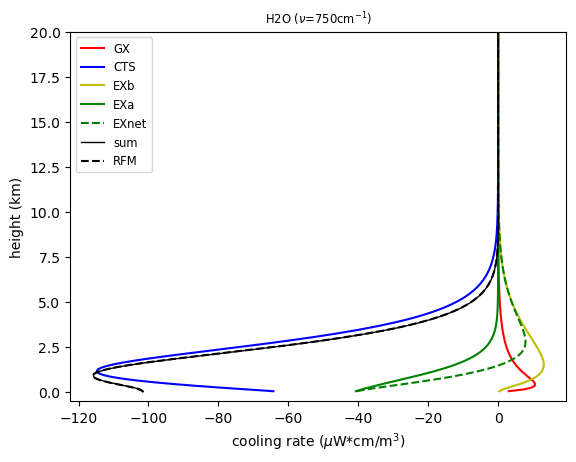

In [32]:
fix, ax = plt.subplots()
knu = get_knu(mynu)
zplt = np.squeeze(0.5*(dataset['RFM']['z'][0:-1]+dataset['RFM']['z'][1:])/1e3)
ax.plot(GX2*1e6,zplt,color='r',label='GX')
ax.plot(CTS2*1e6,zplt,color='b',label='CTS')
ax.plot(EXb2*1e6,zplt,color='y',label='EXb')
ax.plot(EXa2*1e6,zplt,color='g',label='EXa')
ax.plot((EXa2+EXb2)*1e6,zplt,color='g',label='EXnet',linestyle='--')
ssum = (GX2+CTS2+EXb2+EXa2) # spectral sum
ax.plot(ssum*1e6,zplt,color='k',label='sum',linestyle='-',linewidth=1)

# To plot the RFM cooling rate, we need to convert from K*cm/day-> W*cm/m3 -> muW*cm/m3
# W*cm/m3 = rho*cp*dT/dt(K/day)/86400
Qlw = (-1e6*np.squeeze(dataset['RFM']['srhr'][:,knu])/par.nsday)*dataset['RFM']['rho']*dataset['RFM']['cp']

ax.plot(Qlw,dataset['RFM']['z']/1e3,color='k',label='RFM',linestyle='--')
ax.set_ylim([-0.5,20])
#ax.set_xlim([-10,200])
ax.legend(fontsize='small')
ax.set_title(r'H2O ($\nu$='+f'{mynu}'+'cm$^{-1}$)',fontsize='small')

ax.set_ylabel('height (km)')
ax.set_xlabel('cooling rate ($\mu$W*cm/m$^3$)')

NameError: name 'knus' is not defined